In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/AlinaGalenina/ML_HOMEWORK4

Cloning into 'ML_HOMEWORK4'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 1), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [4]:
!pip3 install -r ML_HOMEWORK4/requirements.txt

     |████████████████████████████████| 215kB 7.6MB/s 
     |████████████████████████████████| 122kB 13.7MB/s 
ERROR: Could not find a version that satisfies the requirement ipython==7.19.0 (from -r ML_HOMEWORK4/requirements.txt (line 13)) (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.0, 7.8.0, 7.9.0, 7.10.0, 7.10.1, 7.10.2, 7.11.0, 7.11.1, 7.12.0, 7.13.0, 7.14.0, 7.15.0, 7.16.0, 7.16.1)
ERROR: No matching distribution found for ipython==7.19.0 (f

In [2]:
import matplotlib
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import sys
from tqdm.notebook import tqdm, trange
from time import sleep

from ML_HOMEWORK4.zoo import models
from ML_HOMEWORK4.common.data_loader import DataLoader
from ML_HOMEWORK4.util import visualize_model

## Device configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Configuration

In [15]:
num_epochs = 5
num_classes = 10
batch_size = 512
learning_rate = 0.001
momentum = 0.9


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Pad(3),
    transforms.RandomCrop(32),
    transforms.RandomAffine(degrees=2),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

## Visualization

In [66]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1) 

def vis(ax, epoch, val):
  ax.set_xlim(0, epoch)
  ax.cla()
  ax.plot(epoch, val)
  display(fig)

  clear_output(wait=True)
  plt.pause(0.5)
  



## Load data

In [5]:
data_loader = DataLoader()
data_loader.set_transform(transform)
train_data = data_loader.get_train_data(batch_size)
test_data = data_loader.get_test_data(batch_size)

Files already downloaded and verified


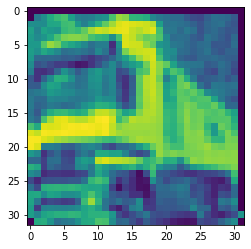

In [6]:
import matplotlib.pyplot as plt
plt.ion()
plt.imshow(train_data.dataset[0][0][0, :, :])
plt.imshow(train_data.dataset[1][0][0, :, :])

In [ ]:
print(train_data.__dict__)

In [7]:
import inspect

models_ = []
for name, obj in inspect.getmembers(models):
    if inspect.isclass(obj) and inspect.getmodule(obj).__name__.split(".")[-1] == "models":
        models_.append(obj())
        print (obj().__class__.__name__)


baselineModel
leakyModel


## Train model

In [8]:
print(models_)

[baselineModel(
  (Conv2dx1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm2dx1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLUx1): ReLU()
  (MaxPool2dx1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2dx2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm2dx2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLUx2): ReLU()
  (MaxPool2dx2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2dx3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm2dx3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLUx3): ReLU()
  (MaxPool2dx3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2dx4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm2dx4): BatchNorm2d(

In [68]:
def train_model(model):
    losses = []
    epochs = []
    metrics = []
    total_step = len(train_data)
    model.train()
    with tqdm(total=num_epochs, file=sys.stdout) as pbar:
      for epoch in range(num_epochs):
        glloss = 0
        for i, (images, labels) in enumerate(train_data):
            # Place training batch onto the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            outputs = model(images)

            # Compute loss.
            loss = loss_function(outputs, labels)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers(i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

            glloss = loss.item()

        # Save the model checkpoint
        metric = eval_model(model)
        metrics.append(metric)
        epochs.append(epoch + 1)
        # print(f"Current epoch is {epoch + 1},  current loss is {glloss}, val accuracy is {metric}")
        pbar.update(1)
        losses.append(glloss)
        torch.save(model.state_dict(), f'model_{model.__class__.__name__}.ckpt')

    return losses, epochs, metrics

## Evaluate model

In [67]:
def eval_model(model):
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance; dropout disabled)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        # print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_data), accuracy))
        return accuracy

## Base Pipeline


Current model is baselineModel



baselineModel best accuracy is 84.58


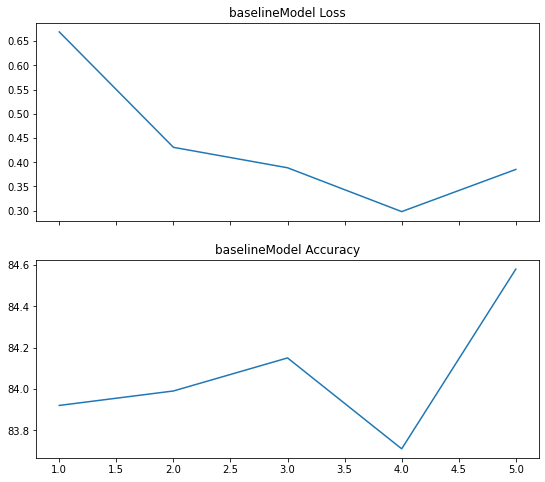


Current model is leakyModel



leakyModel best accuracy is 82.5


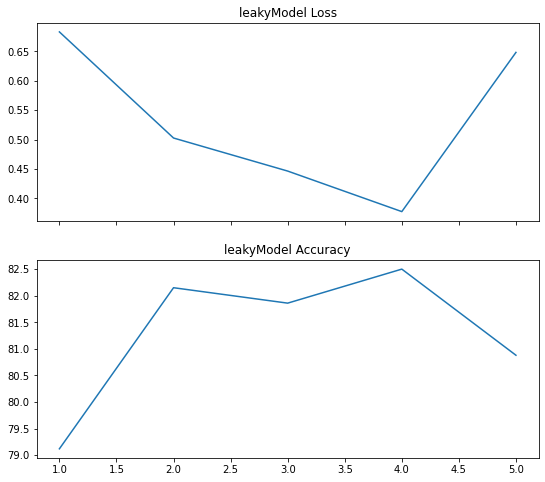

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for model in models_:
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 8))
    print(f"\nCurrent model is {model.__class__.__name__}")
    model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
                                 
    losses, epochs, metrics = train_model(model)

    ax1.plot(epochs, losses)
    ax1.set_title(f"{model.__class__.__name__} Loss")
    ax2.plot(epochs, metrics)
    ax2.set_title(f"{model.__class__.__name__} Accuracy")

    print(f"{model.__class__.__name__} best accuracy is {np.max(metrics)}")
    plt.show()
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


78.66% - baseline

84.85% - top

86.09% - 70 iter

86.42% - 90 iter

In [ ]:
! cp -r ML_HOMEWORK4/ drive/MyDrive/Colab\ Notebooks